# Demo of a weighted generative model
An example weighted generative model implementation

In [8]:
# ensure that this is within the weighted_generative_model environment (and imaging space)
# import requirements
import os
import numpy as np
import scipy
import networkx as nx
import bct as bctpy
import matplotlib.pyplot as plt
import pylab
import copy
from mpl_toolkits.mplot3d import Axes3D
# change to project directory
os.chdir('/imaging/astle/users/da04/Postdoc/weighted_gm/weighted_generative_models')

In [9]:
# set network variables
nnode = 100 # number of nodes
xnode = 5 # x axis
ynode = 5 # y axis
znode = 4 # z axis
# compute inputs
W = np.random.rand(nnode,nnode) # random network
W = W+W.T # made symmetrical
W = np.divide(W,2)
threshold, upper, lower = .9,1,0 # binarised
Atgt = np.where(W>threshold,upper,lower)
Aseed = np.zeros((nnode,nnode)) # seed the seed
x = np.arange(xnode)
y = np.arange(ynode)
z = np.arange(znode)
c = np.array(np.meshgrid(x,y,z)).T.reshape(-1,3) # placed in a grid
d = scipy.spatial.distance.pdist(c)
D = scipy.spatial.distance.squareform(d) # euclidean distance matrix
m = np.count_nonzero(Atgt)/2 # number of connections
eta = -2 # eta parameter
gamma = .5 # gamma parameter
nparas = 1 # number of parameters
model_type = 'matching' # generative model
model_var = 'powerlaw' # wiring equation
epsilon = 1e-6

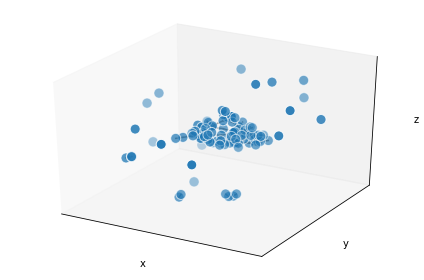

In [10]:
# plot the 3d network
G = nx.Graph(Atgt) # form the graph
# 3d spring layout
pos = nx.spring_layout(G, dim=3, seed=779) # get a 3d spring layout < update this
node_xyz = np.array([pos[v] for v in sorted(G)]) # extract node position from the layout
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()]) # extract edge position from the layout
fig = plt.figure() # create the figure
ax = fig.add_subplot(111, projection="3d")
ax.scatter(*node_xyz.T, s=100, ec="w") # plot the nodes
for vizedge in edge_xyz: # plot the edges
    ax.plot(*vizedge.T, color="tab:gray")
def _format_axes(ax): # some formating
    ax.grid(False) # no grid lines
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis): # remove tick labels
        dim.set_ticks([])
    ax.set_xlabel("x") # axis labels
    ax.set_ylabel("y")
    ax.set_zlabel("z")
_format_axes(ax) # run
fig.tight_layout()
plt.show()

Text(0, 0.5, 'Node')

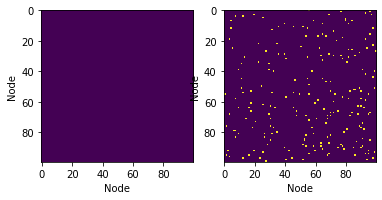

In [5]:
# visualise the seed matrix
subax1 = plt.subplot(121)
plt.imshow(Aseed)
plt.xlabel('Node')
plt.ylabel('Node')
# visualise the target matrix
subax1 = plt.subplot(122)
plt.imshow(Atgt)
plt.xlabel('Node')
plt.ylabel('Node')

In [6]:
# define the matching index
def matching_ind(CIJ):
    """
    For any two nodes u and v, the matching index computes the amount of
    overlap in the connection patterns of u and v. Self-connections and
    u-v connections are ignored. The matching index is a symmetric
    quantity, similar to a correlation or a dot product.

    Parameters
    ----------
    CIJ : NxN :obj:`numpy.ndarray`
        adjacency matrix

    Returns
    -------
    Min : NxN :obj:`numpy.ndarray`
        matching index for incoming connections
    Mout : NxN :obj:`numpy.ndarray`
        matching index for outgoing connections
    Mall : NxN :obj:`numpy.ndarray`
        matching index for all connections

    Notes
    -----
    Does not use self- or cross connections for comparison.
    Does not use connections that are not present in BOTH u and v.
    All output matrices are calculated for upper triangular only.
    """
    n = len(CIJ)

    Min = np.zeros((n, n))
    Mout = np.zeros((n, n))
    Mall = np.zeros((n, n))

    # compare incoming connections
    for i in range(n - 1):
        for j in range(i + 1, n):
            c1i = CIJ[:, i]
            c2i = CIJ[:, j]
            usei = np.logical_or(c1i, c2i)
            usei[i] = 0
            usei[j] = 0
            nconi = np.sum(c1i[usei]) + np.sum(c2i[usei])
            if not nconi:
                Min[i, j] = 0
            else:
                Min[i, j] = 2 * \
                    np.sum(np.logical_and(c1i[usei], c2i[usei])) / nconi

            c1o = CIJ[i, :]
            c2o = CIJ[j, :]
            useo = np.logical_or(c1o, c2o)
            useo[i] = 0
            useo[j] = 0
            ncono = np.sum(c1o[useo]) + np.sum(c2o[useo])
            if not ncono:
                Mout[i, j] = 0
            else:
                Mout[i, j] = 2 * \
                    np.sum(np.logical_and(c1o[useo], c2o[useo])) / ncono

            c1a = np.ravel((c1i, c1o))
            c2a = np.ravel((c2i, c2o))
            usea = np.logical_or(c1a, c2a)
            usea[i] = 0
            usea[i + n] = 0
            usea[j] = 0
            usea[j + n] = 0
            ncona = np.sum(c1a[usea]) + np.sum(c2a[usea])
            if not ncona:
                Mall[i, j] = 0
            else:
                Mall[i, j] = 2 * \
                    np.sum(np.logical_and(c1a[usea], c2a[usea])) / ncona

    Min = Min + Min.T
    Mout = Mout + Mout.T
    Mall = Mall + Mall.T

    return Min, Mout, Mall

In [7]:
# run the binary genreative model
mi, _, _ = matching_ind(Atgt) # compute the matching index on the seed matrix
K = mi + mi.T # symmetrise
A = copy.deepcopy(Aseed) # update notation, note that this makes a pure copy and not a new pointer
n = nnode # update notation
mseed = np.size(np.where(A.flat))//2 # number of connections in the seed
if type(model_var) == tuple: # set the power law or exponential
    mv1, mv2 = model_var
else:
    mv1, mv2 = model_var, model_var
if mv1 in ('powerlaw', 'power_law'):
    Fd = D**eta
elif mv1 in ('exponential',):
    Fd = np.exp(eta*D)
if mv2 in ('powerlaw', 'power_law'):
    Fk = K**gamma
elif mv2 in ('exponential',):
    Fk = np.exp(gamma*K)
Ff = Fd * Fk * np.logical_not(A) # compute the initialised probability matrix
u, v = np.where(np.triu(np.ones((n,n)), 1)) # get row and column indicies
for ii in range(mseed, m): # run the matching model iteratively
    C = np.append(0, np.cumsum(Ff[u, v]))
    r = np.sum(np.random.random()*C[-1] >= C)
    uu = u[r]
    vv = v[r]
    A[uu, vv] = A[vv, uu] = 1
    updateuu, = np.where(np.inner(A, A[:, uu]))
    np.delete(updateuu, np.where(updateuu == uu))
    np.delete(updateuu, np.where(updateuu == vv))
    c1 = np.append(A[:, uu], A[uu, :])
    for i in range(len(updateuu)):
        j = updateuu[i]
        c2 = np.append(A[:, j], A[j, :])
        use = np.logical_or(c1, c2)
        use[uu] = use[uu+n] = use[j] = use[j+n] = 0
        ncon = np.sum(c1[use]) + np.sum(c2[use])
        if ncon == 0:
            K[uu, j] = K[j, uu] = epsilon
        else:
            K[uu, j] = K[j, uu] = (2/ncon*np.sum(np.logical_and(c1[use],c2[use]))+epsilon)
    updatevv, = np.where(np.inner(A, A[:, vv]))
    np.delete(updatevv, np.where(updatevv == uu))
    np.delete(updatevv, np.where(updatevv == vv))
    c1 = np.append(A[:, vv], A[vv, :])
        for i in range(len(updatevv)):
            j = updatevv[i]
            c2 = np.append(A[:, j], A[j, :])
            use = np.logical_or(c1, c2)
            use[vv] = use[vv+n] = use[j] = use[j+n] = 0
            ncon = np.sum(c1[use]) + np.sum(c2[use])
            if ncon == 0:
                K[vv, j] = K[j, vv] = epsilon
            else:
                K[vv, j] = K[j, vv] = (2/ncon*np.sum(np.logical_and(c1[use],c2[use]))+epsilon)
    
Asynth = copy.deepcopy(A) # keep this final simulation

IndentationError: unexpected indent (<ipython-input-7-79dedfd6036a>, line 45)

In [ ]:
# work out various communicability measures
AsynthCom = scipy.linalg.expm(Asynth)
# sum this value
SumCom = np.sum(AsynthCom)
# compute a gradient on this original network with respect to the communicability
grad = np.gradient(Asynth,SumCom)
update = grad[0]
# set the learning rate
alpha = 100
# update the matrix
Asynth = Asynth + alpha*update

In [ ]:
plt.figure(figsize=(15,5))
# visualise the seed
subax1 = plt.subplot(131)
plt.imshow(Aseed)
plt.xlabel('Node')
plt.ylabel('Node')
# visualise the target matrix
subax2 = plt.subplot(132)
plt.imshow(Atgt)
plt.xlabel('Node')
plt.ylabel('Node')
# visualise the simulation
subax3 = plt.subplot(133)
plt.imshow(Asynth)
plt.xlabel('Node')
plt.ylabel('Node')